<a href="https://colab.research.google.com/github/sakshi170920/Myntra_App/blob/main/Demand_Forecasting_Myntra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
from sklearn.preprocessing import LabelEncoder 
import warnings
import statsmodels.api as sm
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
%matplotlib inline 

In [3]:
cd drive/MyDrive/Myntra_dataset/ecommerce_dataset/

/content/drive/MyDrive/Myntra_dataset/ecommerce_dataset


In [6]:
data = pd.read_csv("data.csv", encoding="ISO-8859-1", dtype={'CustomerID': str})
data.shape

(541909, 8)

#**Pre Processing**

In [7]:
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680,France


In [9]:
 #missing values
 data.isnull().sum() / data.shape[0] * 100


InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

In [10]:
data.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID      object
Country         object
dtype: object

In [11]:
data['Description'] = data['Description'].str.strip()
data['InvoiceNo'] = data['InvoiceNo'].astype('str')
data= data[~data['InvoiceNo'].str.contains('C')]

In [12]:
data.isnull().sum() / data.shape[0] * 100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.272990
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     25.289465
Country         0.000000
dtype: float64

In [13]:
data.shape

(532621, 8)

In [14]:
data.describe()

,Quantity,UnitPrice
count,532621.000000,532621.000000
mean,10.239972,3.847621
std,159.593551,41.758023
min,-9600.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,13541.330000


In [15]:
#quantity and price can't be -ve
data = data.loc[data.UnitPrice > 0].copy()
data = data.loc[data.Quantity > 0].copy()

In [16]:
#convert to datetime
data["InvoiceDate"] = pd.to_datetime(data.InvoiceDate, cache=True)
data.InvoiceDate.dtype

dtype('<M8[ns]')

In [17]:
data["Revenue"] = data.Quantity * data.UnitPrice
data["Year"] = data.InvoiceDate.dt.year
data["Quarter"] = data.InvoiceDate.dt.quarter
data["Month"] = data.InvoiceDate.dt.month
data["Week"] = data.InvoiceDate.dt.week
data["Weekday"] = data.InvoiceDate.dt.weekday
data["Day"] = data.InvoiceDate.dt.day
data["Dayofyear"] = data.InvoiceDate.dt.dayofyear
data["Date"] = pd.to_datetime(data[['Year', 'Month', 'Day']])

In [18]:
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010,4,12,48,2,1,335,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,4,12,48,2,1,335,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010,4,12,48,2,1,335,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,4,12,48,2,1,335,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,4,12,48,2,1,335,2010-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20,2011,4,12,49,4,9,343,2011-12-09
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60,2011,4,12,49,4,9,343,2011-12-09
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60,2011,4,12,49,4,9,343,2011-12-09
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60,2011,4,12,49,4,9,343,2011-12-09


##We need product sales , so only **stock code** is used 


In [19]:
grouped_features = ["Date", "Year", "Quarter","Month", "Week", "Weekday", "Dayofyear", "Day",
                    "StockCode"]

In [20]:
daily_data = pd.DataFrame(data.groupby(grouped_features).Quantity.sum(),
                          columns=["Quantity"])
daily_data["Revenue"] = data.groupby(grouped_features).Revenue.sum()
daily_data = daily_data.reset_index()
daily_data.head(5)

,Date,Year,Quarter,Month,Week,Weekday,Dayofyear,Day,StockCode,Quantity,Revenue
0,2010-12-01,2010,4,12,48,2,335,1,10002,60,51.00
1,2010-12-01,2010,4,12,48,2,335,1,10125,2,1.70
2,2010-12-01,2010,4,12,48,2,335,1,10133,5,4.25
3,2010-12-01,2010,4,12,48,2,335,1,10135,1,2.51
4,2010-12-01,2010,4,12,48,2,335,1,11001,3,10.08


In [24]:
low_quantity = daily_data.Quantity.quantile(0.01)
high_quantity = daily_data.Quantity.quantile(0.99)
print((low_quantity, high_quantity))

(1.0, 209.0)


In [26]:
low_revenue = daily_data.Revenue.quantile(0.01)
high_revenue = daily_data.Revenue.quantile(0.99)
print(low_revenue, high_revenue)

0.79 387.0917999999982


In [27]:
#Removing extreme values
daily_data = daily_data.loc[
    (daily_data.Quantity >= low_quantity) & (daily_data.Quantity <= high_quantity)]
daily_data = daily_data.loc[
    (daily_data.Revenue >= low_revenue) & (daily_data.Revenue <= high_revenue)]

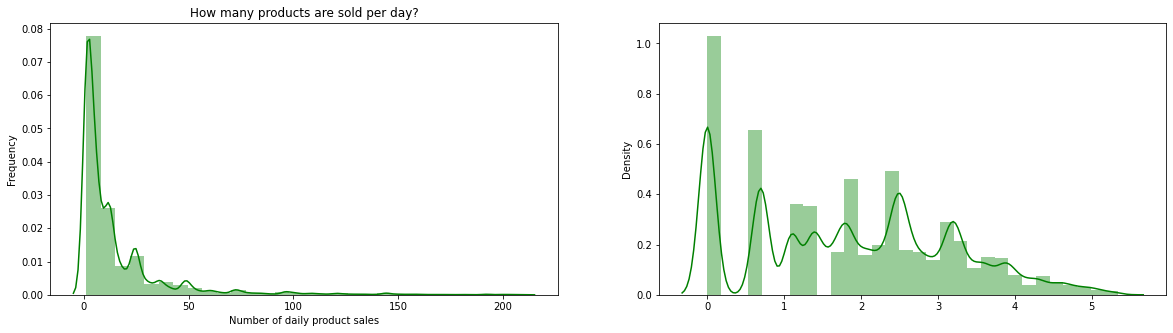

In [28]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(daily_data.Quantity.values, kde=True, ax=ax[0], color="Green", bins=30);
sns.distplot(np.log(daily_data.Quantity.values), kde=True, ax=ax[1], color="Green", bins=30);
ax[0].set_xlabel("Number of daily product sales");
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many products are sold per day?");

In [77]:
def product(stock_code):
  temp = daily_data[daily_data["StockCode"]==stock_code][['Date','Quantity']]
  plt.plot(temp.Date.values, temp.Quantity.values ,color="Blue")
  plt.xlabel("Date");
  plt.ylabel("Quantity");
  plt.title("How products of stockcode : " + stock_code +" are sold ?");

Enter stock code of product : 10002


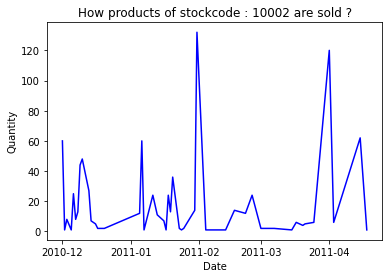

In [78]:
x = input("Enter stock code of product : ")
product(x)

In [79]:
print(daily_data.Date.max(),daily_data.Date.min())
print((daily_data.Date.max()-daily_data.Date.min()))

2011-12-09 00:00:00 2010-12-01 00:00:00
373 days 00:00:00


In [146]:
print(daily_data["StockCode"].value_counts())
stockCode = "22457"
#22457 stock code has highest data for transactions , hence forecasting in done for sales of product eith stock code : 22457

22457     295
20727     291
21080     289
20728     289
82482     289
         ... 
72803b      1
85115B      1
90100       1
84201B      1
90026A      1
Name: StockCode, Length: 3915, dtype: int64


In [210]:
#let data pe df
data = daily_data[daily_data["StockCode"]==stockCode].groupby('Date')['Quantity'].sum().reset_index()
data.head()

,Date,Quantity
0,2010-12-01,38
1,2010-12-02,28
2,2010-12-03,28
3,2010-12-05,25
4,2010-12-06,43


In [211]:
df = data.set_index('Date')
df.index

DatetimeIndex(['2010-12-01', '2010-12-02', '2010-12-03', '2010-12-05',
               '2010-12-06', '2010-12-07', '2010-12-08', '2010-12-09',
               '2010-12-10', '2010-12-12',
               ...
               '2011-11-28', '2011-11-29', '2011-11-30', '2011-12-01',
               '2011-12-02', '2011-12-04', '2011-12-05', '2011-12-06',
               '2011-12-08', '2011-12-09'],
              dtype='datetime64[ns]', name='Date', length=295, freq=None)

In [212]:
#dividing it monthly , to show quantity sold each month
y = df['Quantity'].resample('MS').mean()
y

Date
2010-12-01    32.263158
2011-01-01    33.375000
2011-02-01    21.583333
2011-03-01    32.884615
2011-04-01    32.761905
2011-05-01    21.708333
2011-06-01    19.576923
2011-07-01    30.920000
2011-08-01    22.791667
2011-09-01    27.040000
2011-10-01    31.958333
2011-11-01    30.961538
2011-12-01    38.285714
Freq: MS, Name: Quantity, dtype: float64

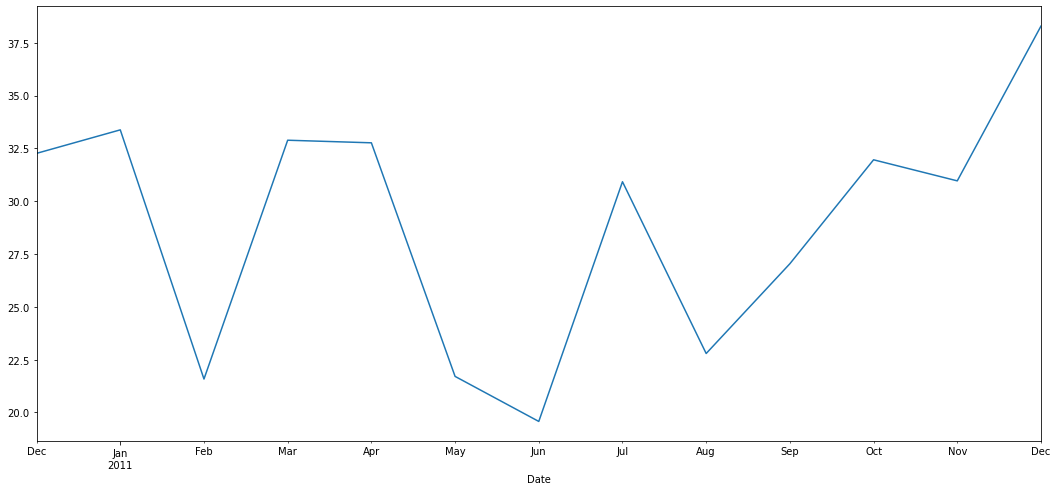

In [213]:
y.plot()

#**Time series forecasting with ARIMA**

ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data

In [214]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


####**Fitting ARIMA Model**
*Forecasting for next 6 months*

Using a **grid search** to find the optimal set of parameters that yields the best performance for our model

In [215]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
          mod = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
          results = mod.fit()
          print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:117.04596273648838
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2.0
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-17.187973863531113
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:98.13294607551174
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-11.04345873743489
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:78.66521298347809
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:2.0
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:68.65841505323073
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:86.58179553603242
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:6.0
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:78.29582726050313
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:8.0
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:78.72008106738608
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:70.5841288599345


In [216]:
#lowest AIC Value = (0,0,0) & (0,1,0)
value1 , value2 = [0,0,0] , [0,1,0]
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0,0,0),
                                seasonal_order=(0,1,0,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         2.7901         -0       -inf      0.000       2.790       2.790


In [217]:
# results.plot_diagnostics(figsize=(16, 8))
# plt.show()
data.Date.max()

Timestamp('2011-12-09 00:00:00')

            lower Quantity  upper Quantity
2012-01-01       30.101161       36.648839
2012-02-01       18.309495       24.857172
2012-03-01       29.610777       36.158454
2012-04-01       29.488066       36.035744
2012-05-01       18.434495       24.982172
2012-06-01       16.303084       22.850762


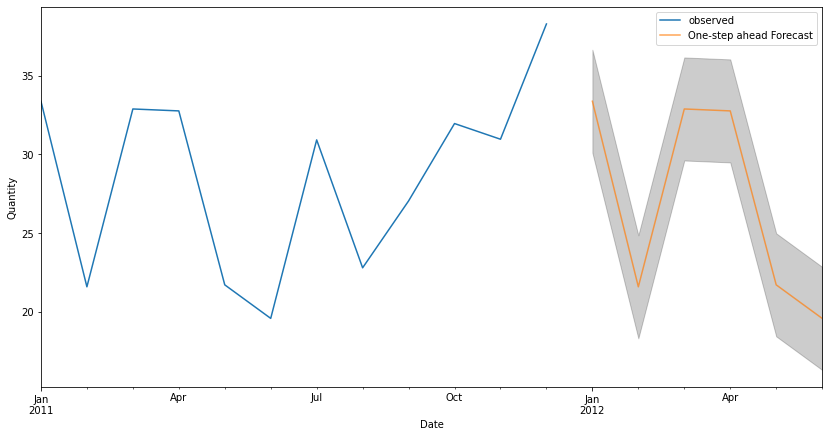

In [218]:
pred = results.get_prediction(start=pd.to_datetime('2012-1-01'),end=pd.to_datetime('2012-6-01'),dynamic=False)

pred_ci = pred.conf_int()
print(pred_ci)
ax = y['2011':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Quantity')
ax.set_label("Sales Forecasting")
plt.legend()

plt.show()

#**Time Series Modeling with Prophet**
*Forecasting for next 5 months*

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds      trend  ...  multiplicative_terms_upper       yhat
0   2010-12-01  29.357609  ...                         0.0  32.529311
1   2010-12-02  29.353867  ...                         0.0  35.005152
2   2010-12-03  29.350126  ...                         0.0  26.036932
3   2010-12-05  29.342642  ...                         0.0  17.200264
4   2010-12-06  29.338901  ...                         0.0  25.783633
..         ...        ...  ...                         ...        ...
295 2012-01-01  28.371448  ...                         0.0  16.229070
296 2012-02-01  28.330033  ...                         0.0  31.501736
297 2012-03-01  28.291291  ...                         0.0  33.942576
298 2012-04-01  28.249877  ...                         0.0  16.107499
299 2012-05-01  28.209798  ...                         0.0  34.089586

[300 rows x 16 columns]


<Figure size 1296x432 with 0 Axes>

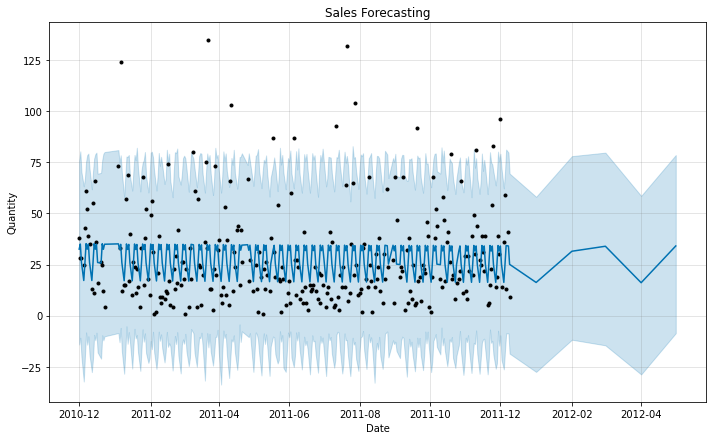

In [208]:
from fbprophet import Prophet

data = data.rename(columns={'Date': 'ds', 'Quantity': 'y'})
model = Prophet(interval_width=0.95)
model.fit(data)


forecast = model.make_future_dataframe(periods=5, freq='MS')
forecast = model.predict(forecast)
print(forecast)
plt.figure(figsize=(18, 6))
model.plot(forecast, xlabel = 'Date', ylabel = 'Quantity')
plt.title('Sales Forecasting');